In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import jax.random as jr
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.option_classes import  DIFFRAX_BACKEND, TSIT5, DOPRI5, DOPRI8
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})
plt.style.use('default')

code_length = 0.1 * u.pc
code_mass = 10**4 * u.Msun
# code_mass = 1000 * u.Msun
G = 1
code_time = 1 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  




# IMF AND MASS SEGREGATION

In [5]:
config = SimulationConfig(N_particles = 1_000, 
                          return_snapshots = True, 
                          num_snapshots = 1000,  
                          num_timesteps = 1000, 
                          external_accelerations=(), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          fixed_timestep=False,
                          diffrax_solver=DOPRI8,
                          ) #default values

params = SimulationParams(t_end = (1 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4 * u.Msun).to(code_units.code_mass).value,
                                                        a=(10 * u.pc).to(code_units.code_length).value),                   
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

# we use salpeter IMF alpha=2.35
def sample_powerlaw(key, N, m_min, m_max, alpha, Mtot):
    """Sample N masses from a power law, normalized to Mtot."""
    u = jr.uniform(key, shape=(N,))
    a = 1.0 - alpha
    m_raw = (u * (m_max**a - m_min**a) + m_min**a) ** (1.0 / a)

    # Normalize to total mass
    m = m_raw * (Mtot / jnp.sum(m_raw))
    return m

# Example
key = jr.PRNGKey(0)
mass = sample_powerlaw(key, N=config.N_particles, m_min=1, m_max=100.0, alpha=2.35, Mtot=params.Plummer_params.Mtot*code_units.code_mass.to(u.Msun) )
mass = mass * u.Msun.to(code_units.code_mass)# convert to code units
print(mass.sum())  # ~ 1.0


1.0000001


Text(0, 0.5, 'Mass [Msun]')

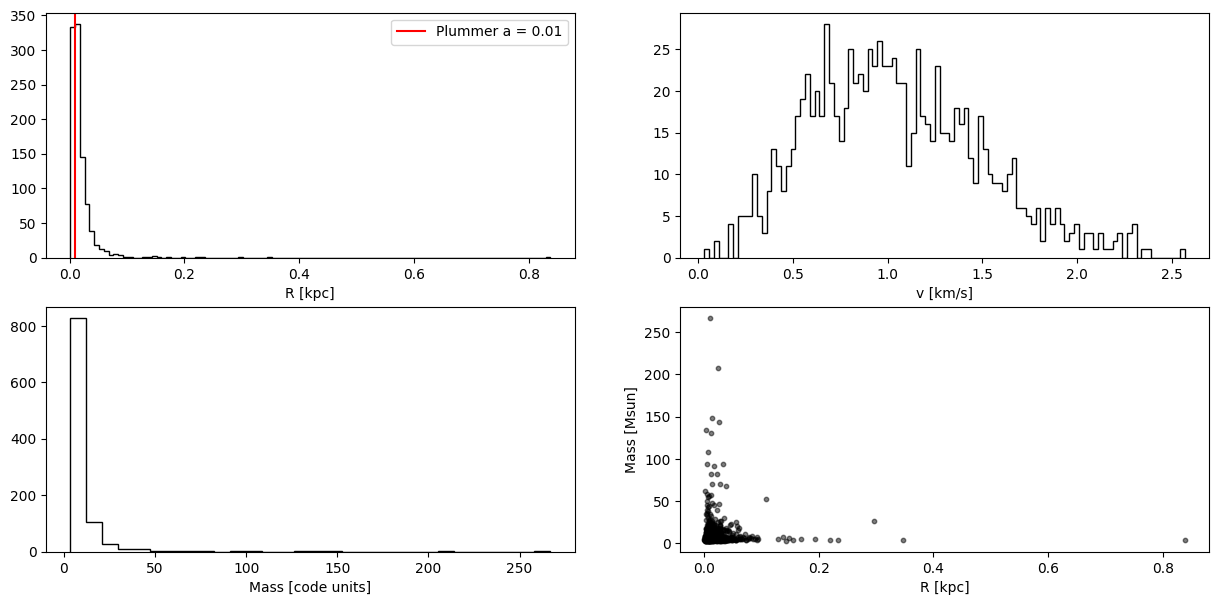

In [6]:
#Plummer sphere distribution
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(221)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a = {}'.format((params.Plummer_params.a*code_units.code_length).to(u.kpc).value))
ax.legend()
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(222)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')

ax = fig.add_subplot(223)
ax.hist(mass * code_units.code_mass.to(u.Msun), bins=30, histtype='step', color='k')
ax.set_xlabel('Mass [code units]')


ax = fig.add_subplot(224)
ax.scatter(jnp.linalg.norm(positions, axis=1) * code_units.code_length.to(u.kpc), 
           mass * code_units.code_mass.to(u.Msun),
           s=10, color='k', alpha=0.5)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('Mass [Msun]')

In [7]:
#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

if config.return_snapshots: 
    snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))
else:
    final_state = jax.block_until_ready(time_integration(initial_state, mass, config, params))

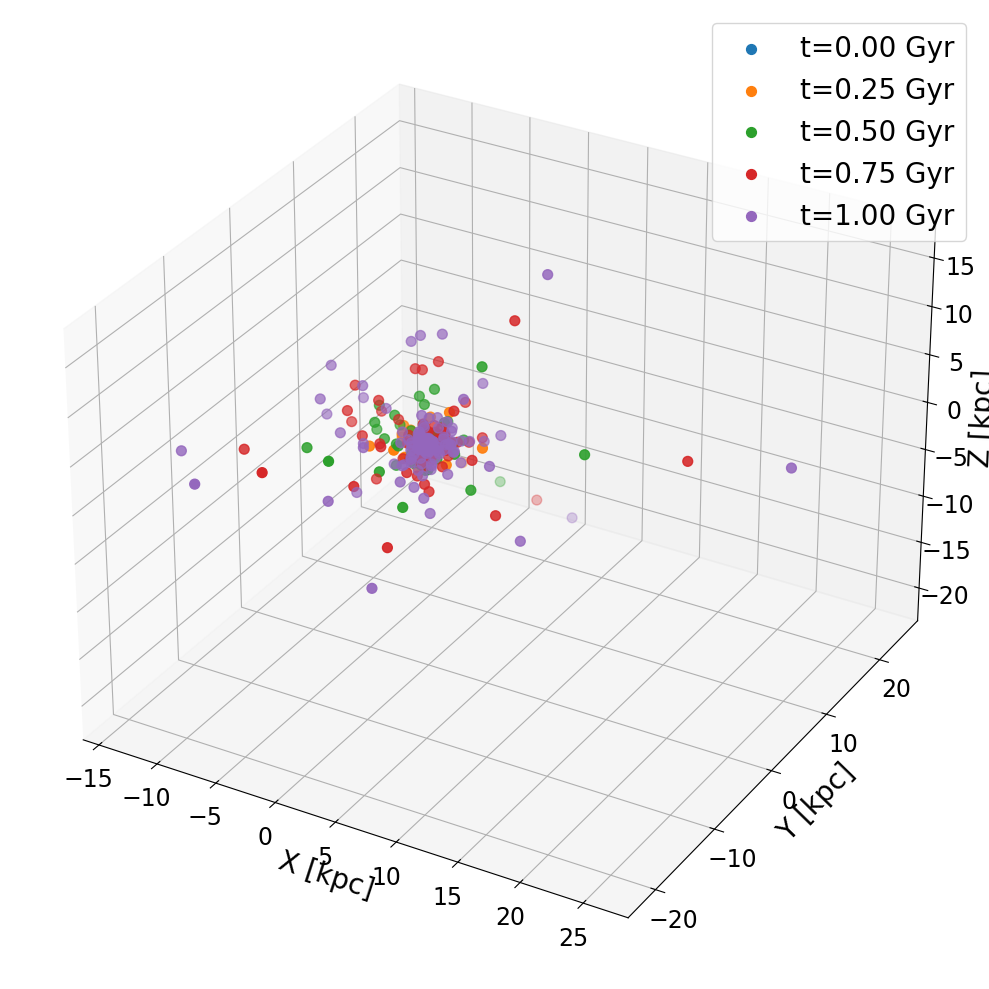

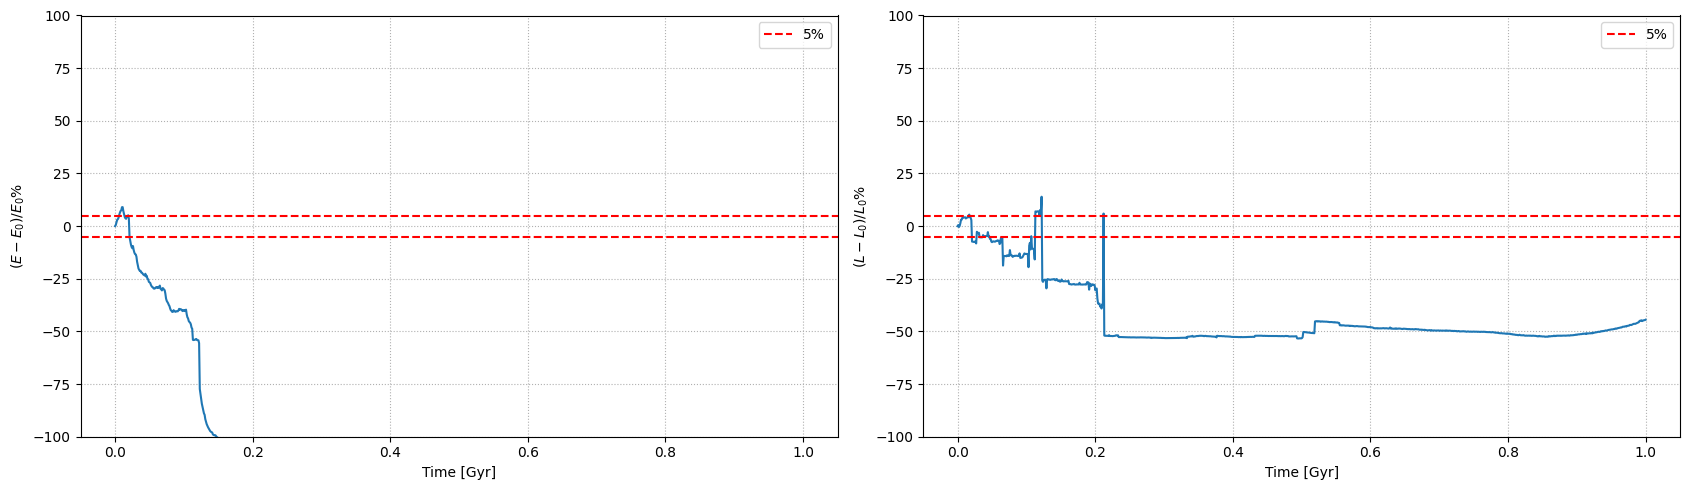

In [8]:
fig = plt.figure(figsize=(10, 10), tight_layout=True,)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), 
               label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}",
               s=50)


ax.set_xlabel('X [kpc]', fontsize=20)
ax.set_ylabel('Y [kpc]', fontsize=20)
ax.set_zlabel('Z [kpc]', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=17)  # 


# Remove the grid
# ax.grid(False)

energy_angular_momentum_plot(snapshots, code_units,)


Text(0, 0.5, 'Mass [Msun]')

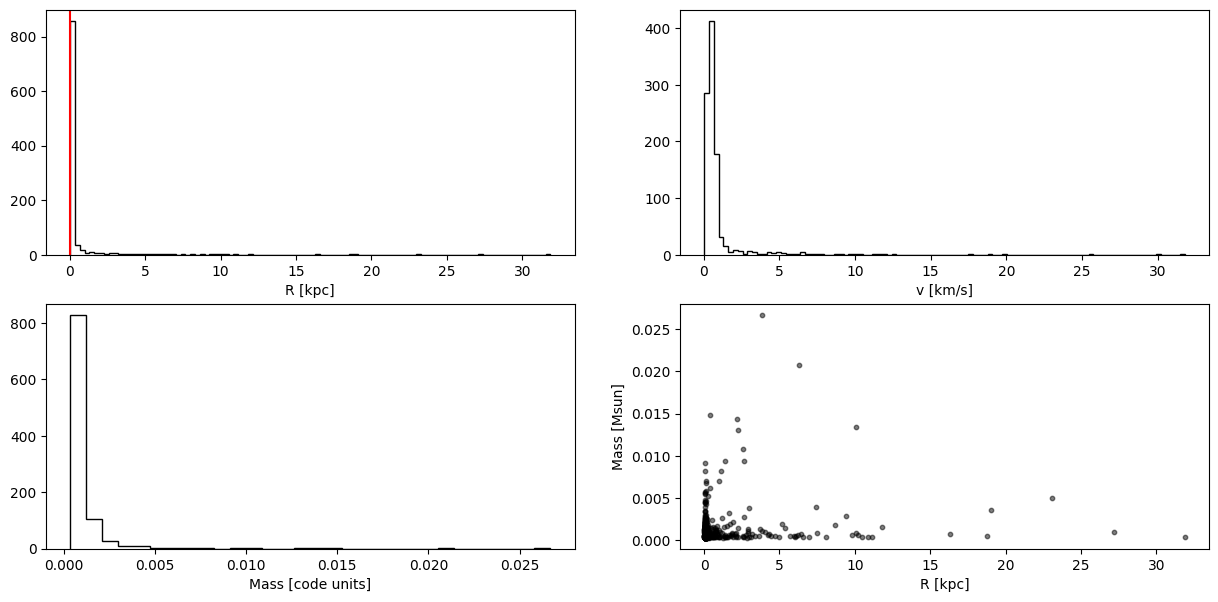

In [9]:
new_positions = snapshots.states[-1, :, 0]
new_velocities = snapshots.states[-1, :, 1] 

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(221)
ax.hist((jnp.linalg.norm(new_positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(222)
ax.hist(jnp.linalg.norm((new_velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')

ax = fig.add_subplot(223)
ax.hist(mass, bins=30, histtype='step', color='k')
ax.set_xlabel('Mass [code units]')


ax = fig.add_subplot(224)
ax.scatter(jnp.linalg.norm(new_positions, axis=1) * code_units.code_length.to(u.kpc), 
           mass,
           s=10, color='k', alpha=0.5)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('Mass [Msun]')